# Motor Control Bench Test Procedure

This notebook describes a procedure that exercises the following functionality:

1. Tachometers.
2. Arm/disarm and manual motor control.
3. Speed measurement.
4. PID motor control.

In [1]:
%load_ext autoreload
%autoreload 2

## Vehicle part identification and orientation conventions

![img](./Assets/RoverInTestBenchTopView.jpeg)

### Connection to vehicle and health check

Find which port is the vehicle connected to.
In linux, usually it is:

- **Development mode (STM32 UART3 / USB)**: ttyACM0, ttyACM1, ...
- **Production mode (STM32 UART 1)**: ttyUSB0, ttyUSB1, ...

Development/production mode must match the UartTcTmHandle parameter chosen when building firmware:

~~~c++
/* USER CODE END Header_DefaultTaskMain */
void DefaultTaskMain(void *argument)
{
  /* USER CODE BEGIN 5 */
	Config.UartTcTmHandle = &huart3; // Development mode
	//Config.UartTcTmHandle = &huart1; // Production mode
    
    /* ... */
    
	ApplicationMain(&Config);
  /* USER CODE END 5 */
}
~~~

In [ ]:
!ls /dev/ttyUSB*

In [2]:
!ls /dev/ttyACM*

/dev/ttyACM0


In [3]:
import sys
sys.path.append("../")
from rover.vehicleif import VehicleIF

#VEHICLE_UART_TCTM_PORT = "/dev/ttyUSB1" # Production mode
VEHICLE_UART_TCTM_PORT = "/dev/ttyACM0" # Development mode

connection_params = {
    "mode": VehicleIF.MODE_DIRECT_SERIAL,
    "port": VEHICLE_UART_TCTM_PORT,
    "baudrate": 115200
}

vehicle = VehicleIF(connection_params,debug=False)
vehicle.capture_path = "./captures"

For a quick health check, see current telemetry state:

In [4]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 290
   OnBoardTime: 174005
   ReceivedPackets: 0
   GeneralStatus: 0x00000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 290
   OnBoardTime: 174005
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


For a quick command test, turn on and off led.

In [5]:
# Led on
vehicle.control_led(0x00000001)

Sent: 0x 40 3C 05 00 00 00 00 01 A2 0A  (10 bytes)


In [6]:
# Led off
vehicle.control_led(0x00000000)

Sent: 0x 40 3C 05 00 00 00 00 00 93 0A  (10 bytes)


## Procedure

### 1. Tachometer readings

**Preconditions**

- Reset the vehicle to ensure all tachometer readings are at zero.

In [7]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 13
   OnBoardTime: 7804
   ReceivedPackets: 2
   GeneralStatus: 0x01000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 12
   OnBoardTime: 7204
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


Start logging telemetry.

In [8]:
vehicle.start_telemetry_csv_logging()

In [9]:
input("Move wheels and press any key when done")

Move wheels and press any key when done 


''

- Move wheel 1.
- Move wheel 2.
- Move wheel 3.
- Move wheel 4.

Stop logging telemetry.

In [10]:
vehicle.stop_telemetry_csv_logging()

In [11]:
!ls {vehicle.capture_path}

tctm.telemetry.GeneralTelemetry.csv  tctm.telemetry.MotorControlTelemetry.csv
tctm.telemetry.IMUTelemetry.csv


In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df.head(5)

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags
0,17,10204,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,18,10804,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,19,11404,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,20,12004,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,21,12604,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


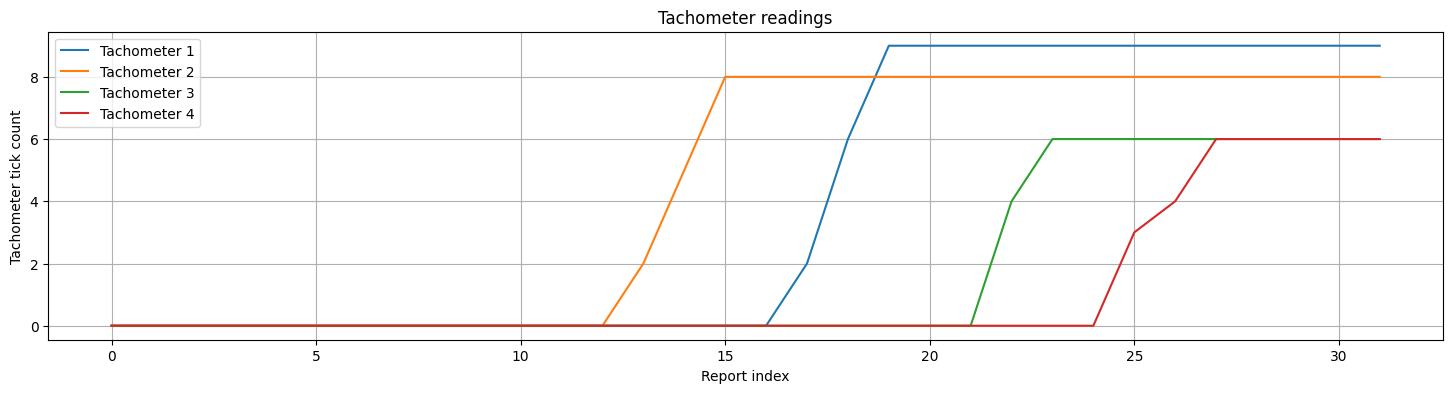

In [13]:
fig, axes = plt.subplots(1,1,figsize=(18,4))
axes.plot(motor_control_tm_df.Tachometer1)
axes.plot(motor_control_tm_df.Tachometer2)
axes.plot(motor_control_tm_df.Tachometer3)
axes.plot(motor_control_tm_df.Tachometer4)
axes.grid(which="Both")
axes.set_xlabel("Report index")
axes.set_ylabel("Tachometer tick count")
axes.legend(["Tachometer 1","Tachometer 2","Tachometer 3","Tachometer 4"])
axes.set_title("Tachometer readings");

### 2. Manual motor control

In [7]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 339
   OnBoardTime: 203405
   ReceivedPackets: 2
   GeneralStatus: 0x01000000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 339
   OnBoardTime: 203405
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


Attempt to start motor when disarmed (should fail).

In [8]:
vehicle.set_motor_throttles(0.5,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 3F 00 00 00 00 00 00 00 CC 0A  (18 bytes)


In [9]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 349
   OnBoardTime: 209405
   ReceivedPackets: 3
   GeneralStatus: 0x00010000
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 349
   OnBoardTime: 209405
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000000
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


Arm in manual mode.

In [14]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_MANUAL)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)


In [11]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 366
   OnBoardTime: 219605
   ReceivedPackets: 4
   GeneralStatus: 0x01030001
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 366
   OnBoardTime: 219605
   Throttle1: 0.0
   Throttle2: 0.0
   Tachometer1: 0
   Tachometer2: 0
   Tachometer3: 0
   Tachometer4: 0
   MeasuredSpeed1: 0.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 0.0
   SetpointSpeed2: 0.0
   StatusFlags: 0x00000001
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


Check vehicle right side moves forward.

In [12]:
vehicle.set_motor_throttles(0.5,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 3F 00 00 00 00 00 00 00 CC 0A  (18 bytes)


Check vehicle right side moves backward.

In [56]:
vehicle.set_motor_throttles(-0.5,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 BF 00 00 00 00 00 00 00 0E 0A  (18 bytes)


Stop.

In [13]:
vehicle.set_motor_throttles(0.0,0.0,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 00 00 00 00 00 00 00 00 D4 0A  (18 bytes)


Check vehicle left side moves backward.

In [58]:
vehicle.set_motor_throttles(0.0,0.5,0x2)

Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3F 00 00 00 FC 0A  (18 bytes)


Check vehicle left side moves backward.

In [59]:
vehicle.set_motor_throttles(0.0,-0.5,0x2)

Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 BF 00 00 00 0D 0A  (18 bytes)


Both sides forward.

In [60]:
vehicle.set_motor_throttles(0.5,0.5,0x3)

Sent: 0x 40 3C 0D 01 00 00 00 03 3F 00 00 00 3F 00 00 00 51 0A  (18 bytes)


Both sides backward.

In [61]:
vehicle.set_motor_throttles(-0.5,-0.5,0x3)

Sent: 0x 40 3C 0D 01 00 00 00 03 BF 00 00 00 BF 00 00 00 62 0A  (18 bytes)


Disarm.

In [367]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

Sent: 0x 40 3C 05 03 00 00 00 00 D7 0A  (10 bytes)


### 3. Speed measurement

In [4]:
import numpy as np
import time

In [5]:
MIN_ABS_THROTTLE=0.0
MAX_ABS_THROTTLE=1.0
N_SAMPLES = 32
INTERVAL_IN_S = 1.0
SUSTAIN_INTERVAL_IN_S = 5.0

In [6]:
def do_motor_curve(vehicle, min_value, max_value, n_samples, interval, side):
    for throttle in np.linspace(min_value,max_value,n_samples):
        if side == 'left':
            vehicle.set_motor_throttles(throttle,0.0,0x1)
        elif side == 'right':
            vehicle.set_motor_throttles(0.0, throttle, 0x2)
        else:
            vehicle.set_motor_throttles(throttle,throttle,0x3)
        time.sleep(interval)

In [7]:
def perform_motor_test(vehicle, min_abs_throttle, max_abs_throttle, n_samples, interval, sustain_interval, side):
    # Start logging
    vehicle.start_telemetry_csv_logging()

    # Arm 
    vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_MANUAL)
    time.sleep(0.5)

    # Ramp up
    do_motor_curve(vehicle, min_abs_throttle, max_abs_throttle, n_samples, interval, side)
    # Sustain
    time.sleep(sustain_interval)
    # Ramp down
    do_motor_curve(vehicle, max_abs_throttle, min_abs_throttle, n_samples, interval, side)

    # Disarm
    vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

    # Stop logging
    vehicle.stop_telemetry_csv_logging()

#### 3.1 Left side

In [15]:
SIDE = "left" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 00 00 00 00 00 00 00 00 D4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D 04 21 08 00 00 00 00 FB 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D 84 21 08 00 00 00 00 47 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3D C6 31 8C 00 00 00 00 D3 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 04 21 08 00 00 00 00 20 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 25 29 4A 00 00 00 00 6A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 46 31 8C 00 00 00 00 B4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 67 39 CE 00 00 00 00 FE 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 84 21 08 00 00 00 00 9C 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E 94 A5 29 00 00 00 00 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E A5 29 4A 00 00 00 00 D6 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E B5 AD 6B 00 00 00 00 F3 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 01 3E C6 31 8C 00 0

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/nhorro/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/nhorro/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "../rover/endpoint/serialif.py", line 36, in _listen
    if self.serial and self.serial.is_open and self.serial.in_waiting:
  File "/home/nhorro/anaconda3/lib/python3.8/site-packages/serial/serialposix.py", line 549, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 5] Input/output error


In [86]:
!cp {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry.csv {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry-LeftThrottleRamp.csv

In [87]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry-LeftThrottleRamp.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df.tail()

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed12
111,139,83405,0.064516,0.0,4209,4004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
112,140,84005,0.032258,0.0,4209,4004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
113,141,84605,0.032258,0.0,4209,4004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
114,142,85205,0.000000,0.0,4209,4004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
115,143,85805,0.000000,0.0,4209,4004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


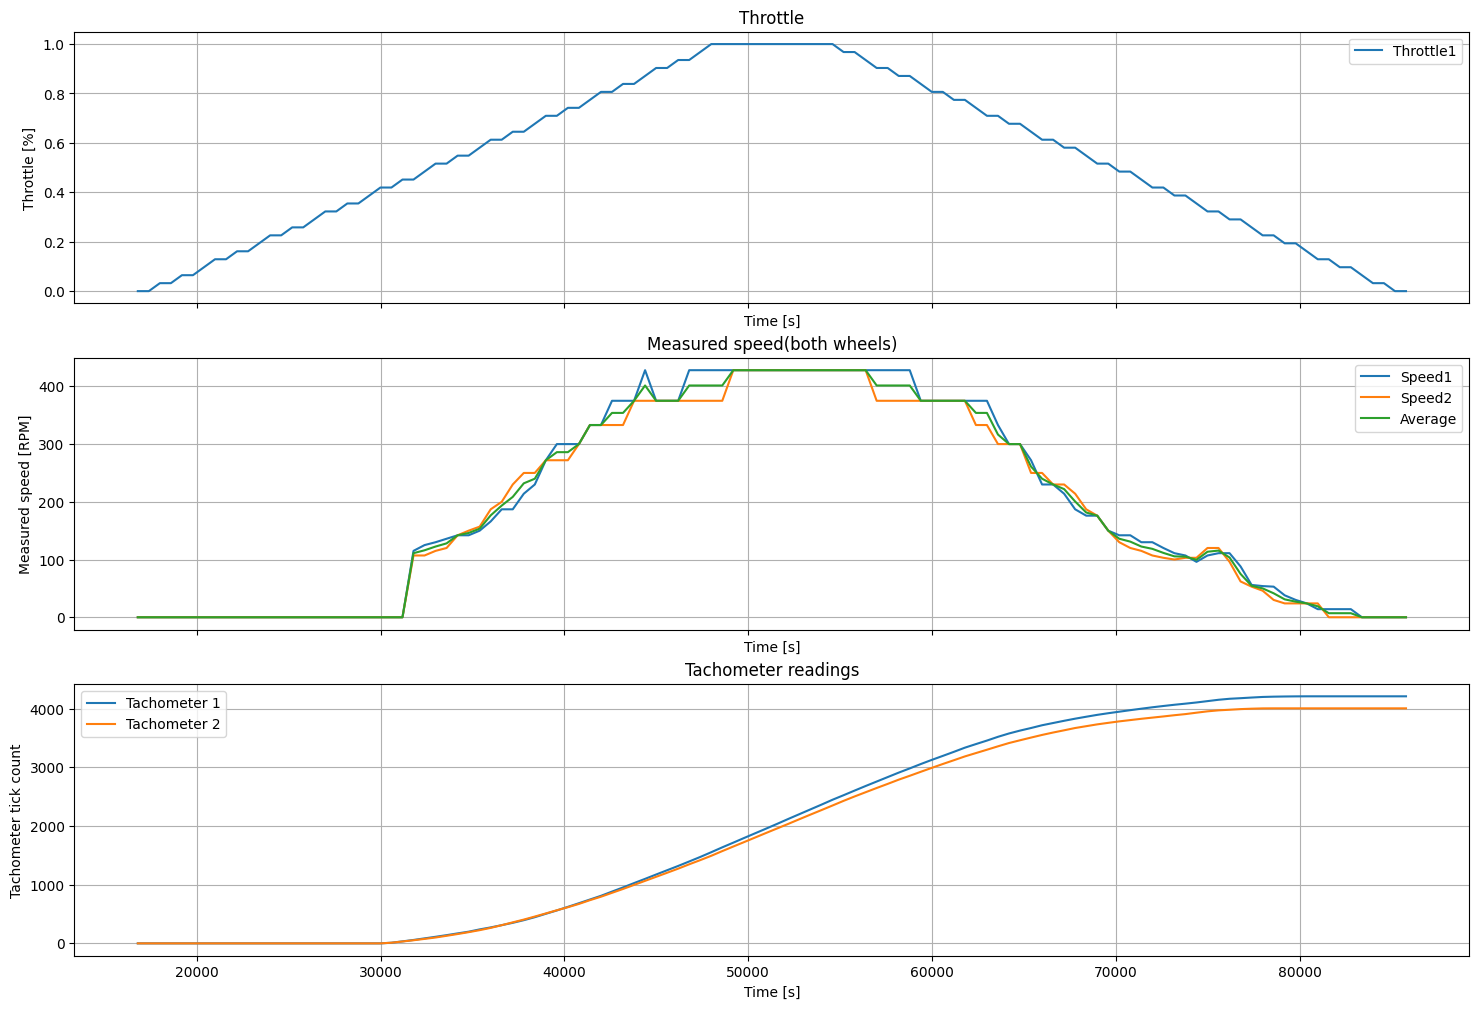

In [88]:
fig, axes = plt.subplots(3,1,figsize=(18,12),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].set_title("Measured speed(both wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Tachometer tick count")
axes[2].legend(["Tachometer 1","Tachometer 2"])
axes[2].set_title("Tachometer readings");

#### 3.2 Right side

In [92]:
SIDE = "right" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 00 00 00 00 3A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D 04 21 08 43 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D 84 21 08 96 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3D C6 31 8C 38 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 04 21 08 DF 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 25 29 4A 88 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 46 31 8C 71 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 67 39 CE 26 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 84 21 08 0A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E 94 A5 29 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E A5 29 4A 5D 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E B5 AD 6B EE 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 02 00 00 00 00 3E C

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed34
111,292,175205,0.0,0.064516,4209,4004,3833,3921,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
112,293,175805,0.0,0.064516,4209,4004,3833,3921,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
113,294,176405,0.0,0.032258,4209,4004,3833,3921,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
114,295,177005,0.0,0.000000,4209,4004,3833,3921,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
115,296,177605,0.0,0.000000,4209,4004,3833,3921,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [93]:
!cp {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry.csv {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry-RightThrottleRamp.csv

In [104]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry-RightThrottleRamp.csv"))
motor_control_tm_df["AverageSpeed34"] = (motor_control_tm_df.MeasuredSpeed3+ motor_control_tm_df.MeasuredSpeed4)/2
motor_control_tm_df.tail()

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed34
111,469,281405,0.0,0.064516,4209,4004,7542,7764,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
112,470,282005,0.0,0.064516,4209,4004,7542,7764,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
113,471,282605,0.0,0.032258,4209,4004,7542,7764,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
114,472,283205,0.0,0.032258,4209,4004,7542,7764,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
115,473,283805,0.0,0.000000,4209,4004,7542,7764,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


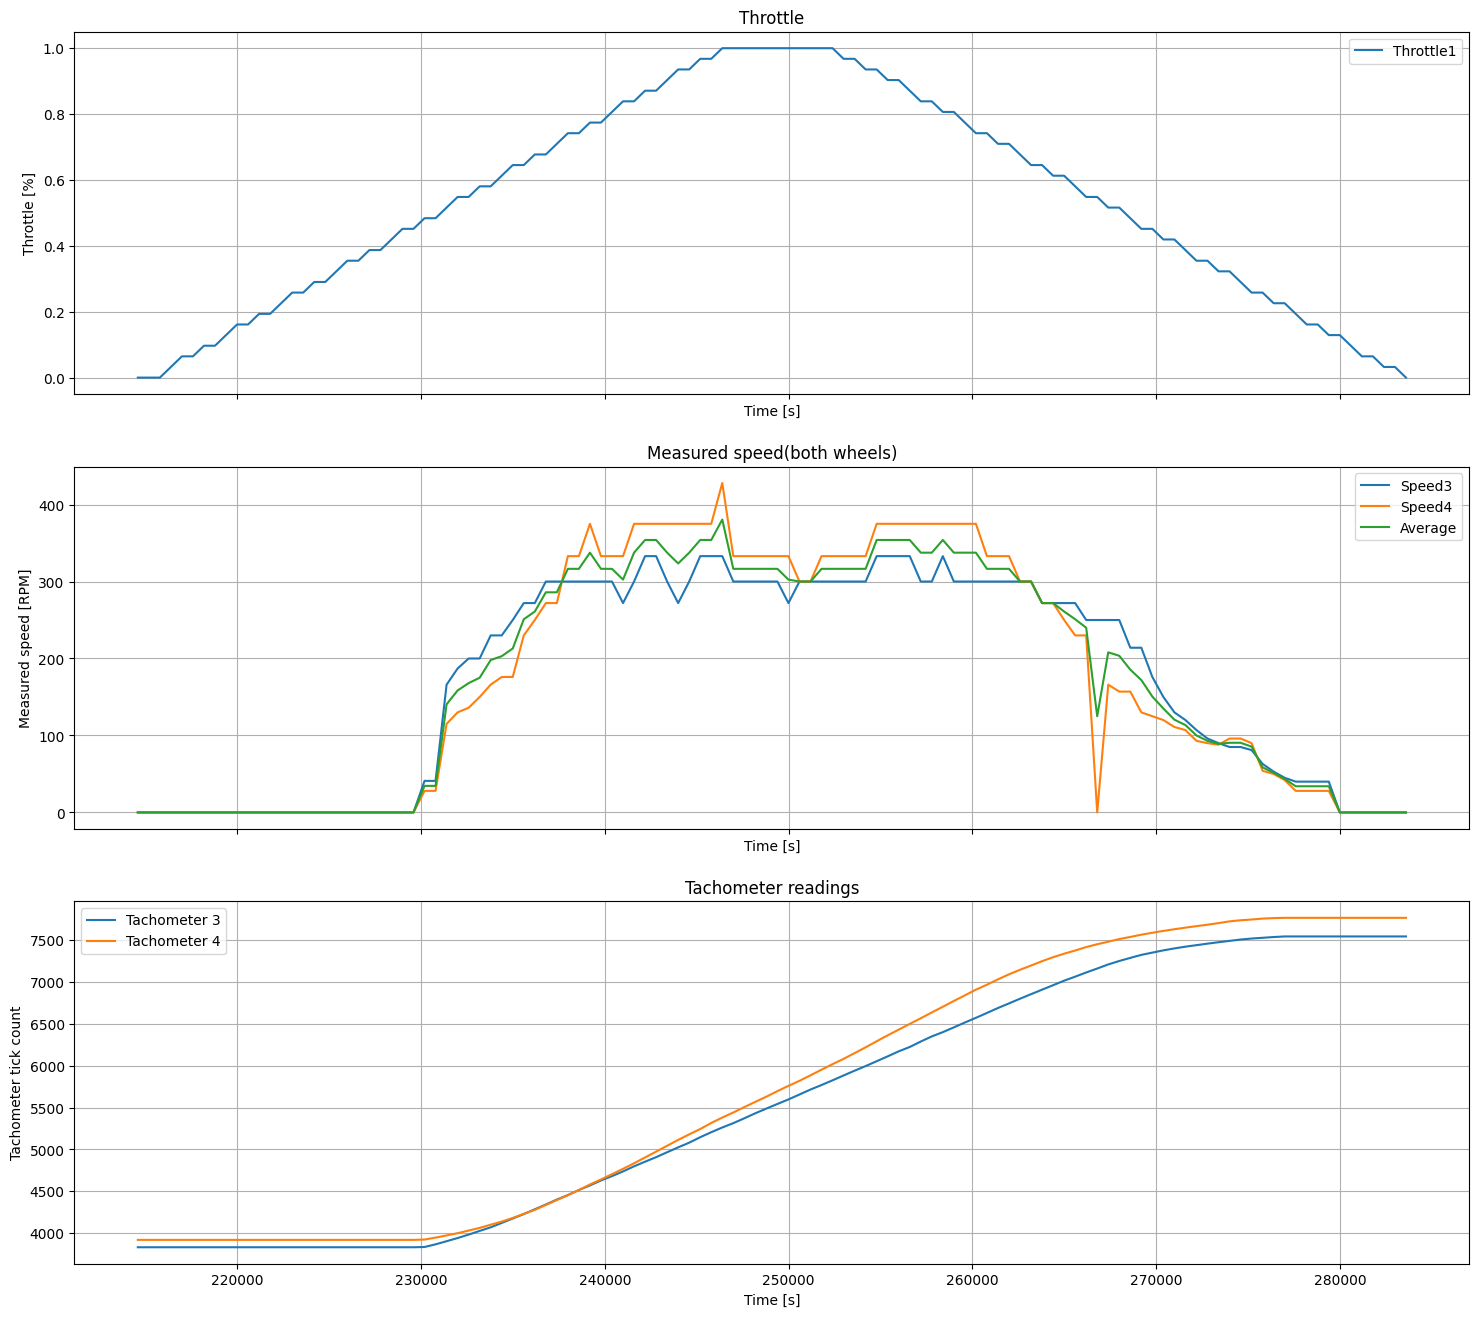

In [97]:
fig, axes = plt.subplots(3,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle2)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed3)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed4)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34)
axes[1].set_title("Measured speed(both wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed3","Speed4","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer3)
axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer4)
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Tachometer tick count")
axes[2].legend(["Tachometer 3","Tachometer 4"])
axes[2].set_title("Tachometer readings");

#### 3.3 Both sides

In [106]:
SIDE = "both" # left, right, or both
perform_motor_test(vehicle,MIN_ABS_THROTTLE,MAX_ABS_THROTTLE,N_SAMPLES,INTERVAL_IN_S,SUSTAIN_INTERVAL_IN_S,SIDE)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 00 00 00 00 00 00 00 00 8F 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D 04 21 08 3D 04 21 08 D9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D 84 21 08 3D 84 21 08 B0 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3D C6 31 8C 3D C6 31 8C 8A 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 04 21 08 3E 04 21 08 9E 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 25 29 4A 3E 25 29 4A 83 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 46 31 8C 3E 46 31 8C A4 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 67 39 CE 3E 67 39 CE B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 84 21 08 3E 84 21 08 F7 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E 94 A5 29 3E 94 A5 29 61 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E A5 29 4A 3E A5 29 4A EA 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E B5 AD 6B 3E B5 AD 6B 7C 0A  (18 bytes)
Sent: 0x 40 3C 0D 01 00 00 00 03 3E C6 31 8C 3E C

In [107]:
!cp {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry.csv {vehicle.capture_path}/tctm.telemetry.MotorControlTelemetry-BothThrottleRamp.csv

In [108]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry-BothThrottleRamp.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df["AverageSpeed34"] = (motor_control_tm_df.MeasuredSpeed3+ motor_control_tm_df.MeasuredSpeed4)/2
motor_control_tm_df.tail()

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed12,AverageSpeed34
111,122,73205,0.064516,0.064516,2672,2420,3074,2777,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
112,123,73805,0.064516,0.064516,2672,2420,3074,2777,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
113,124,74405,0.032258,0.032258,2672,2420,3074,2777,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
114,125,75005,0.032258,0.032258,2672,2420,3074,2777,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
115,126,75605,0.000000,0.000000,2672,2420,3074,2777,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0


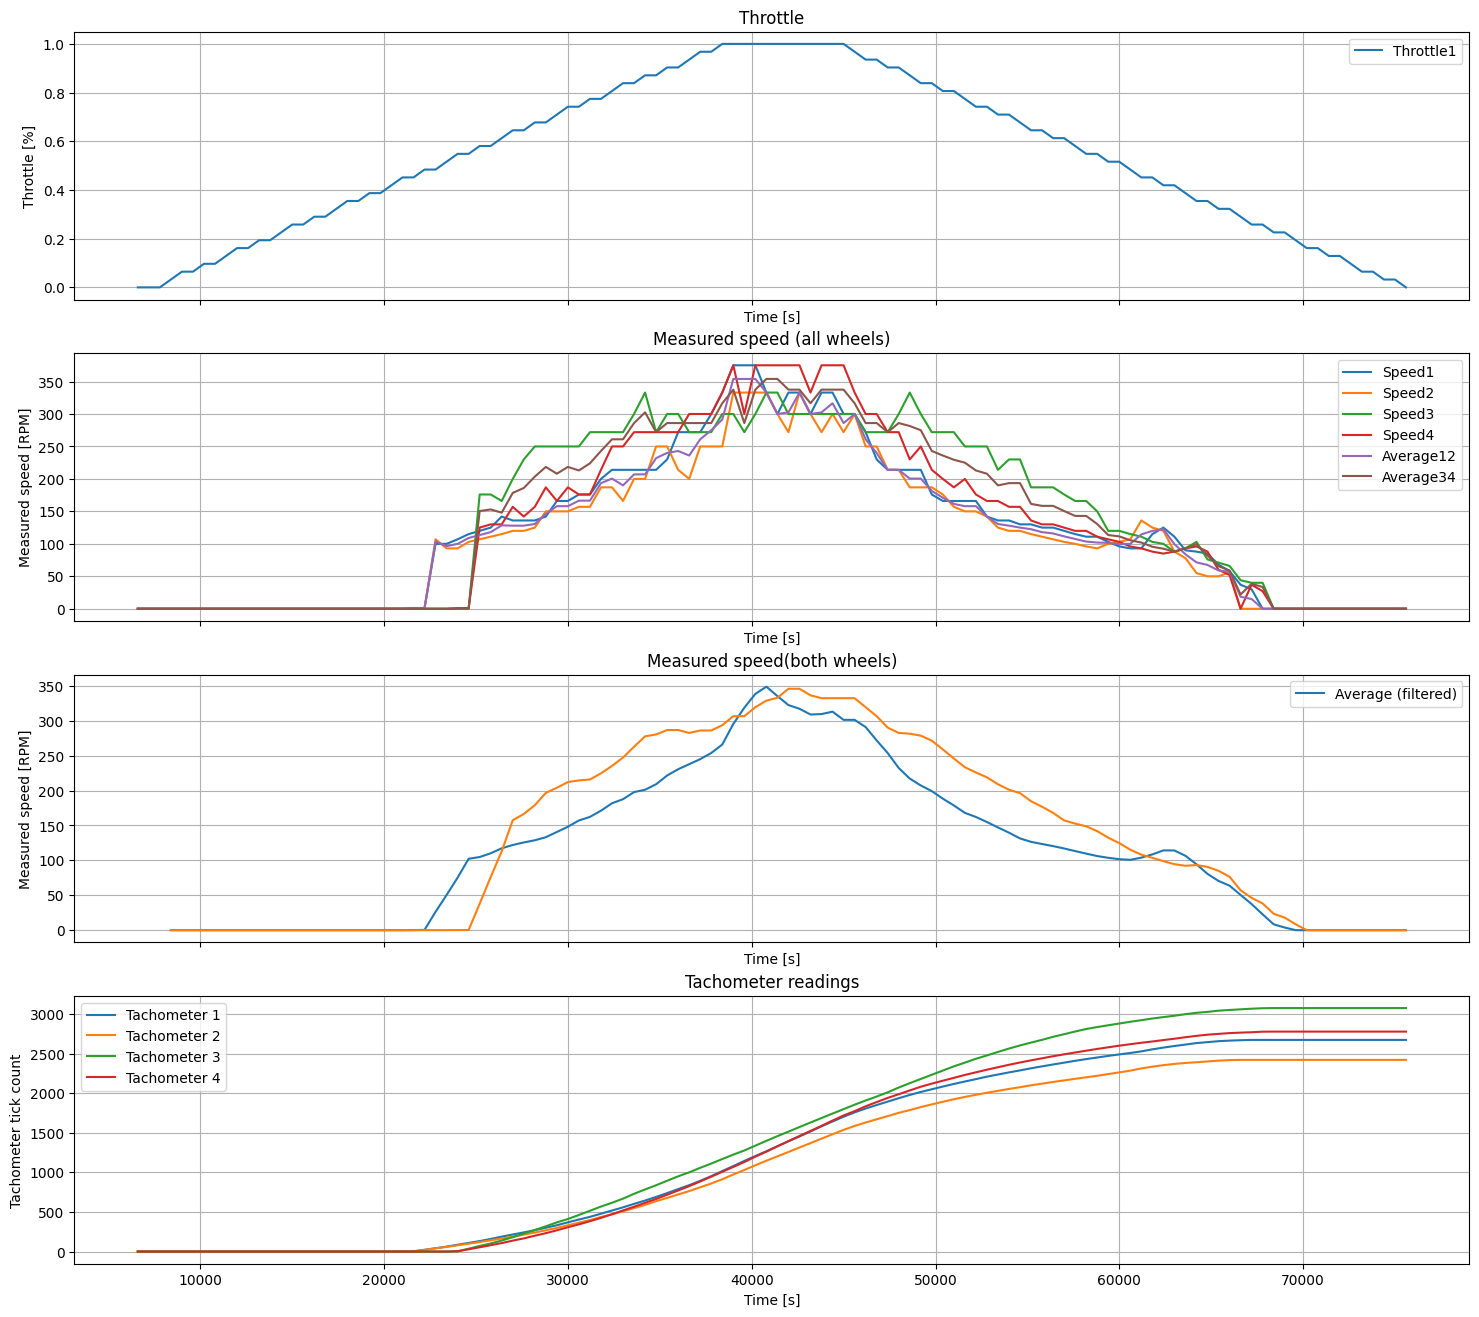

In [109]:
fig, axes = plt.subplots(4,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed3)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed4)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34)
axes[1].set_title("Measured speed (all wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Speed3","Speed4","Average12","Average34",])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12.rolling(4).mean())
axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed34.rolling(4).mean())
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Average (filtered)"])

axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer3)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer4)
axes[3].grid(which="Both")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Tachometer tick count")
axes[3].legend(["Tachometer 1","Tachometer 2","Tachometer 3","Tachometer 4"])
axes[3].set_title("Tachometer readings");

### 4. PID motor control

In [833]:
vehicle.print_telemetry()

General Telemetry
   TelemetryCycle: 1885
   OnBoardTime: 1131004
   ReceivedPackets: 43
   GeneralStatus: 0x01040002
   Debug1: 0x00000000
   Debug2: 0x00000000
Motor Telemetry
   TelemetryCycle: 1885
   OnBoardTime: 1131004
   Throttle1: 0.2149999886751175
   Throttle2: 0.3999999761581421
   Tachometer1: 26892
   Tachometer2: 21992
   Tachometer3: 20534
   Tachometer4: 18431
   MeasuredSpeed1: 37.0
   MeasuredSpeed2: 0.0
   MeasuredSpeed3: 0.0
   MeasuredSpeed4: 0.0
   SetpointSpeed1: 40.0
   SetpointSpeed2: 40.0
   StatusFlags: 0x00000002
IMU Telemetry
   TelemetryCycle: 0
   OnBoardTime: 0
   Roll: 0.0
   Pitch: 0.0
   Yaw: 0.0


In [839]:
vehicle.set_pid_parameters(0.01,1,1)

Sent: 0x 40 3C 0D 04 3C 23 D7 0A 00 00 00 00 00 00 00 00 E2 0A  (18 bytes)


In [840]:
# Start logging
vehicle.start_telemetry_csv_logging()

In [845]:
MIN_SPEED = 40
MAX_SPEED = 400
N_SAMPLES = 64
INTERVAL=0.1

# Start logging
vehicle.start_telemetry_csv_logging()

vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_PID)
time.sleep(1)

for speed in np.linspace(MIN_SPEED,MAX_SPEED,N_SAMPLES):
    vehicle.set_motor_speeds(speed,speed,0x3)
    time.sleep(INTERVAL)

# Sustain
time.sleep(INTERVAL*50)


for speed in np.linspace(MAX_SPEED,MIN_SPEED,N_SAMPLES):
    vehicle.set_motor_speeds(speed,speed,0x3)
    time.sleep(INTERVAL)

time.sleep(1)

# Stop logging
vehicle.stop_telemetry_csv_logging()     

# Disarm
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

Sent: 0x 40 3C 05 03 00 00 00 02 B5 0A  (10 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 20 00 00 42 20 00 00 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 36 DB 6E 42 36 DB 6E EA 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 4D B6 DB 42 4D B6 DB 7F 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 64 92 49 42 64 92 49 01 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 7B 6D B7 42 7B 6D B7 8F 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 89 24 92 42 89 24 92 AE 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 94 92 49 42 94 92 49 B9 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 A0 00 00 42 A0 00 00 D0 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 AB 6D B7 42 AB 6D B7 61 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 B6 DB 6E 42 B6 DB 6E 83 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 C2 49 25 42 C2 49 25 B3 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 CD B6 DB 42 CD B6 DB 16 0A  (18 bytes)
Sent: 0x 40 3C 0D 02 00 00 00 03 42 D9 24 92 42 D

AttributeError: module 'time' has no attribute 'sustain'

In [848]:
motor_control_tm_df = pd.read_csv(os.path.join(vehicle.capture_path,"tctm.telemetry.MotorControlTelemetry.csv"))
motor_control_tm_df["AverageSpeed12"] = (motor_control_tm_df.MeasuredSpeed1+ motor_control_tm_df.MeasuredSpeed2)/2
motor_control_tm_df.tail()

,TelemetryCycle,OnBoardTime,Throttle1,Throttle2,Tachometer1,Tachometer2,Tachometer3,Tachometer4,MeasuredSpeed1,MeasuredSpeed2,MeasuredSpeed3,MeasuredSpeed4,SetpointSpeed1,SetpointSpeed2,StatusFlags,AverageSpeed12
235,2355.0,1413004,0.0,0.0,27994,22177,21648,19685,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0
236,2356.0,1413604,0.0,0.0,27994,22177,21648,19685,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0
237,2357.0,1414204,0.0,0.0,27994,22177,21648,19685,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0
238,2358.0,1414804,0.0,0.0,27994,22177,21648,19685,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0
239,2359.0,1415404,0.0,0.0,27994,22177,21648,19685,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0


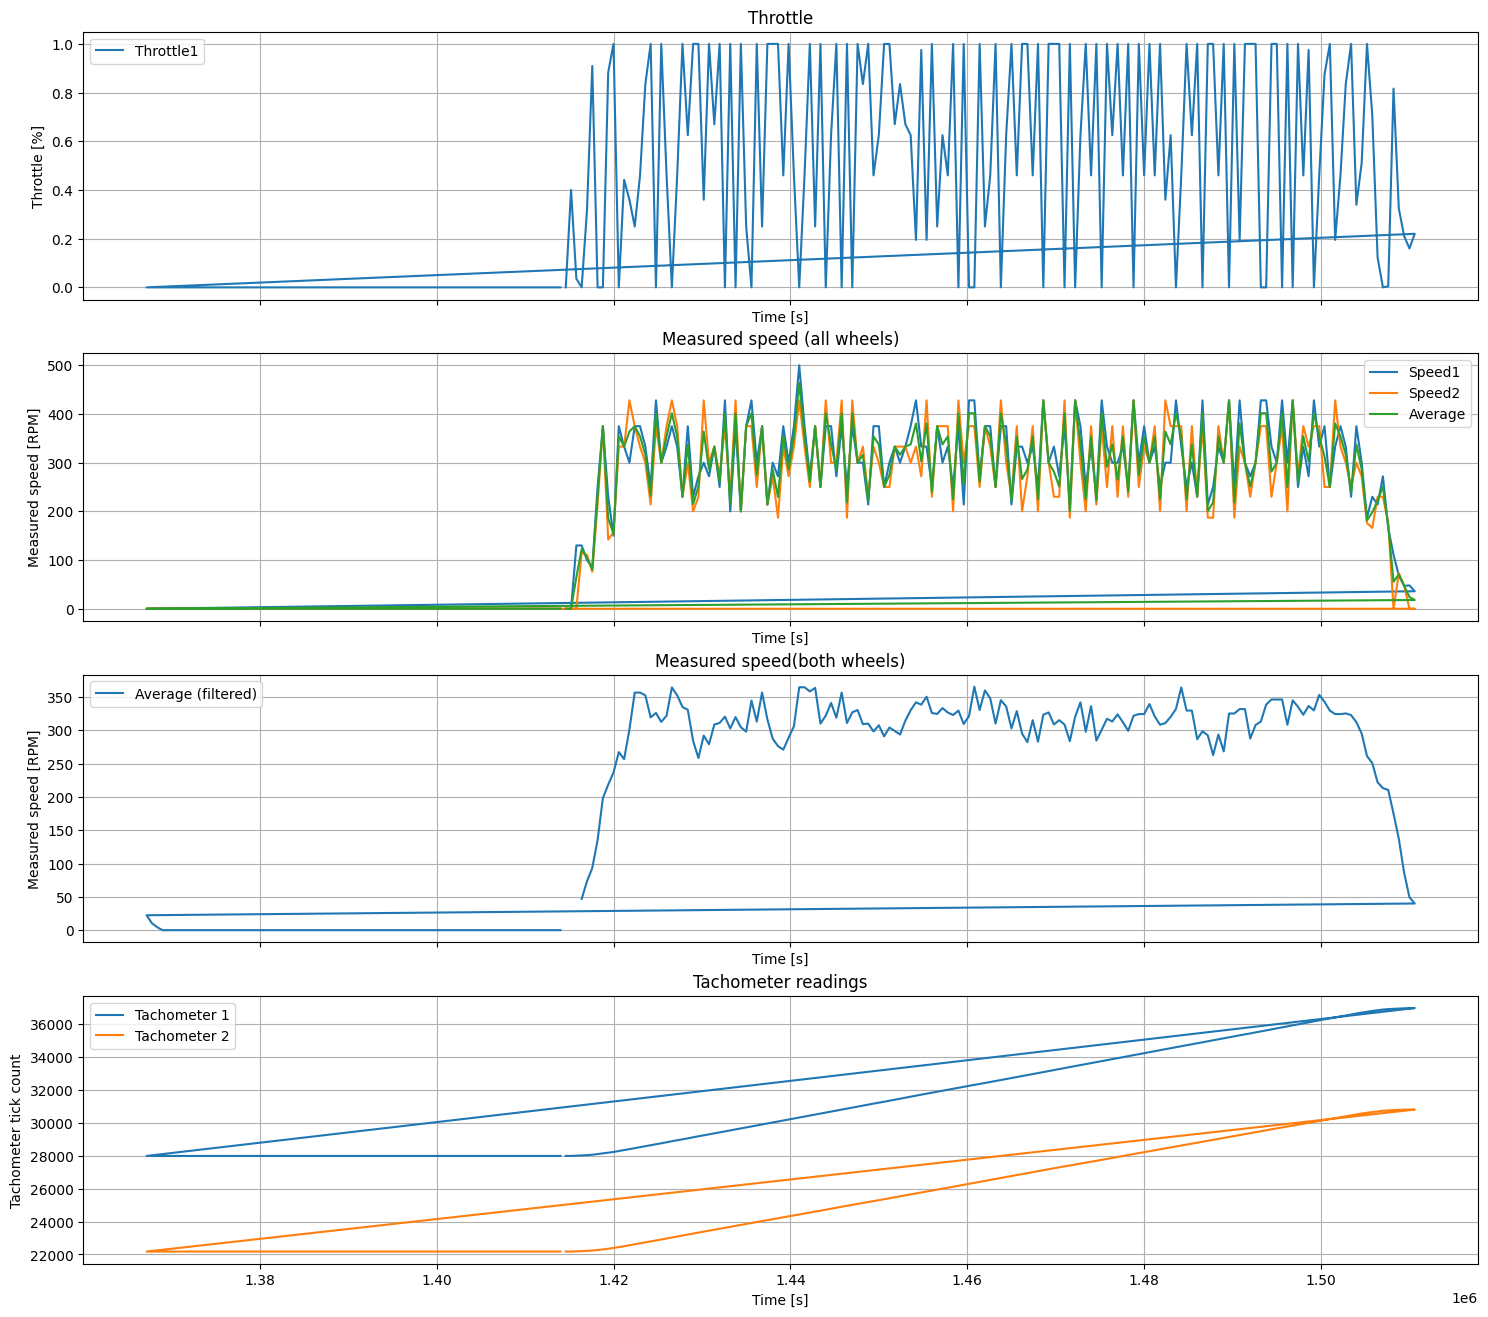

In [849]:
fig, axes = plt.subplots(4,1,figsize=(18,16),sharex=True)
axes[0].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Throttle1)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed1)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.MeasuredSpeed2)
axes[1].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12)
axes[1].set_title("Measured speed (all wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Average"])

axes[2].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.AverageSpeed12.rolling(4).mean())
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Average (filtered)"])

axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer1)
axes[3].plot(motor_control_tm_df.OnBoardTime-motor_control_tm_df.OnBoardTime.iloc[0]/1000,motor_control_tm_df.Tachometer2)
axes[3].grid(which="Both")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("Tachometer tick count")
axes[3].legend(["Tachometer 1","Tachometer 2",])
axes[3].set_title("Tachometer readings");

## Teardown

In [ ]:
vehicle.shutdown()

# Debug
<hr/>

In [37]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_DISARM)

Sent: 0x 40 3C 05 03 00 00 00 00 D7 0A  (10 bytes)


In [35]:
vehicle.set_motor_control_mode(VehicleIF.MOTOR_MODE_ARM_MANUAL)

Sent: 0x 40 3C 05 03 00 00 00 01 E6 0A  (10 bytes)


In [36]:
vehicle.set_motor_throttles(0.4,0.,0x1)

Sent: 0x 40 3C 0D 01 00 00 00 01 3E CC CC CD 00 00 00 00 E2 0A  (18 bytes)


In [ ]:
vehicle.print_telemetry()